#### In this problem we use "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand.

Here, We are particularly interested in detecting faces in a given image.

#### To use the model first, we need to import the model and its supporting files for the model to function. 

We see the below steps to import the model.

### First lets install numpy and restart the runtime.  Go to: Runtime > Restart runtime in the top menu

You can comment or skip the below command after running once in a runtime. 

In [1]:
!pip install numpy==1.16.1

     |████████████████████████████████| 17.0MB 126kB/s 
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.15.0 which is incompatible.
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.1+cu100 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
ls -l

total 8
drwx------ 3 root root 4096 Nov 17 10:19 drive/
drwxr-xr-x 1 root root 4096 Nov  6 16:17 sample_data/


In [5]:
cd /content/drive/My Drive/Colab Notebooks/ACVprj1

/content/drive/My Drive/Colab Notebooks/ACVprj1


### Import MobileNet model given in file `mn_model.py`

In [6]:
### Import MobileNet model given in file `mn_model.py`

from mn_model import mn_model

Using TensorFlow backend.


### Import the BatchGenerator and SSDLoss functions in given files `face_generator.py`, `keras_ssd_loss` and `ssd_box_encode_decode_utils.py` as well, used in MobileNet model

In [7]:
#### Import the BatchGenerator and SSDLoss functions as well, used in MobileNet model

from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

face_generator.py:39: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 87

In [0]:

import warnings
warnings.filterwarnings("ignore")

from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K 
from keras.models import load_model
from math import ceil 
import numpy as np 
from termcolor import colored

from mn_model import mn_model
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

# training parameters
from keras import backend as K
import scipy.misc as sm


## Set the parameters for the model

#### We need to customize the model parameters according to our problem as given below.

#### Set n_classes (no.of classes) = 2, as we are interested in only face detection. 
#### `Face` will be one class and everything else comes under other class (we can call it as `background`)

#### Set class_names = ["background", "face"]

In [0]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

det_model_path = "./"

### Now, we have imported the model and its dependencies. The next thing is to import the dataset for the model to train on. For this, we are using the WIDER FACE dataset. 

#### To make the dataset available follow the steps given below.


1. Create a folder in your google drive for this project. 

2. Download the train and test dataset files given in .zip format into your drive folder you created for the project in step-1.

3. Set the project path variable according to the folders you created to use for this project in your google drive. 

      `project_path = "/content/drive/My Drive/DLCP/"`

4. Now, as we mount the drive the images will be available to use for training and testing but in zip format.

5. So, lets extract the images from the zipfiles by using the code given of zipfile module.







In [0]:
#from google.colab import drive  ---already done

In [0]:
#drive.mount('/content/drive') --- already done

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_path = "/content/drive/My Drive/Colab Notebooks/ACVprj1/"

In [0]:
train_images_path = project_path + 'WIDER_train.zip'
test_images_path = project_path + 'WIDER_val.zip'

In [0]:
import zipfile
archive = zipfile.ZipFile(train_images_path, 'r')
archive.extractall()

In [0]:
archive = zipfile.ZipFile(test_images_path, 'r')
archive.extractall()

### Now, the images are available. The next thing we need is to get the labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 

#### Follow the below steps to get those labels available.


Load the  '' `wider_train_small.npy`'' file given to check the information given about the dataset. In this file you can see the information about each image in the dataset in a list with following elemets:
      

        1.   Image filename (str)
        2.   Image filename (str)
        3.   Image size (list) [height, width]
        4.   List of bounding box co-ordinates and Class label (list) [[a,b,c,d], Class label, ...]
        
        where,
        a,b,c,d are the four co-ordinates of the bounding box
        Class label is the position of object as mentioned in `class_names` list above.

In [0]:
data = np.load('./wider_train_small.npy').item()

In [16]:
### Printed first element to check the above given information.

for key in data:
    print key
    print data[key]
    break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


 As we can see from the above output all the information mentioned above is there for all the images.

### Now, load the files `wider_trian.npy` and `wider_val.npy`

In [0]:
train_data = 'wider_train_small.npy'
test_data = 'wider_val_small.npy'

x = np.load(train_data)

### Now, call the imported model with the given parameters and freeze all the layers in the model with names not having ''`detection`'' word as prefix.

As we are not training the model from scratch, we are freezing all the above layers in the model having only last few layers while training to update their weights according to the problem in hand. This is called as **Transfer Learning**.

In [18]:
# build the keras model
# this model is not retrained, we are doing it from scratch 

K.clear_session()
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

W1117 10:42:23.877221 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1117 10:42:23.881618 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1117 10:42:23.914952 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1117 10:42:23.920835 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1117 10:42:23.937746 14

====> Model Specific data
====> Height, Width, Channels : 512 512 3


W1117 10:42:24.306972 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

W1117 10:42:24.412177 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



#### Write code to freeze all the layers in the above model with names not having ''`detection`'' word as prefix.

In [0]:
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df=pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [20]:

df[80:90]

,Layer Type,Layer Name,Layer Trainable
80,<keras.layers.normalization.BatchNormalization object at 0x7fc2b7d0bf90>,conv_dw_13_bn,True
81,<keras.layers.core.Activation object at 0x7fc2b7d0be90>,conv_dw_13_relu,True
82,<keras.layers.convolutional.Conv2D object at 0x7fc2b7d22490>,conv_pw_13,True
83,<keras.layers.normalization.BatchNormalization object at 0x7fc2b7cebcd0>,conv_pw_13_bn,True
84,<keras.layers.core.Activation object at 0x7fc2b7ceb5d0>,conv_pw_13_relu,True
85,<keras.layers.convolutional.Conv2D object at 0x7fc2b7cf3a10>,detection_conv6_1,True
86,<keras.layers.normalization.BatchNormalization object at 0x7fc2b7c44690>,detection_conv6_1_bn,True
87,<keras.layers.core.Lambda object at 0x7fc2b7c580d0>,detection_conv6_1_nonlin,True
88,<mn_model.DepthwiseConv2D object at 0x7fc2b7c76810>,detection_conv6_2_conv_dw_1,True
89,<keras.layers.normalization.BatchNormalization object at 0x7fc2b7c20750>,detection_conv6_2_conv_dw_1_bn,True


In [0]:
for layer in model.layers[:85]:
    layer.trainable=False
for layer in model.layers[85:]:
    layer.trainable=True

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda1 (Lambda)                (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda2 (Lambda)                (None, 512, 512, 3)  0           lambda1[0][0]                    
__________________________________________________________________________________________________
lambda3 (Lambda)                (None, 512, 512, 3)  0           lambda2[0][0]                    
__________________________________________________________________________________________________
conv1 (Con

### After making the model ready for transfer learning, load the weights of the model given in file ''`mobilenet_1_0_224_tf.h5`''

In [0]:
model.load_weights('./mobilenet_1_0_224_tf.h5',by_name= True)

#### Using the functions given in the model, we are trying to divide the dataset into train and validation samples. Run the below code.

In [25]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("==>VALIDATION")

val_dataset = BatchGenerator(images_path=test_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=test_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate training batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Training batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))

==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128
==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of validation samples = 60


### Now, lets setup things for training by initilaizing required variables like learning rate, epochs, optimizer and loss function(SSDLoss) to compile the model

In [26]:
# setting up training 

# batch_size and no.of epochs

batch_size = 16
num_epochs = 10

#Learning rate
base_lr = 0.002

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W1117 10:46:40.714109 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1117 10:46:40.731827 140475577685888 module_wrapper.py:139] From keras_ssd_loss.py:97: The name tf.log is deprecated. Please use tf.math.log instead.

W1117 10:46:40.738734 140475577685888 deprecation.py:323] From keras_ssd_loss.py:129: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W1117 10:46:40.752345 140475577685888 deprecation.py:323] From keras_ssd_loss.py:76: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1117 10:46:40.769844 140475577685888 deprecation.py:323] From keras_ssd_loss.py:162: to_int32 (from tensorf

### Lets add early stopping and model checkpoint layers on validation loss with some patience values and using fit_generator function to train the model on data generated batch-by-batch by a Python generator, `train_generator` object as generator.


We are using checkpoint to save the best model based on validation accuracy.

#### Write code for early_stopping and model_checkpoint layers. Using model.fit_generator train the model and save the best weight file.

In [27]:
weight_path = "./"

def scheduler(epoch):
  if epoch%10==0 and epoch!=0:
    lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, lr*.95)
    print("lr changed to {}".format(lr*.95))
  else: 
    print("lr remains {}".format(K.get_value(model.optimizer.lr)))

  return K.get_value(model.optimizer.lr)

lr_schedule = LearningRateScheduler(scheduler)

plateau = ReduceLROnPlateau(monitor='val_loss', factor = 0.3, patience =4, epsilon=0.001, cooldown=0)
tensorboard = TensorBoard(log_dir='./logs/trial1/', histogram_freq=1, batch_size=16, write_graph=True, write_grads=True, 
                          write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=100)
model_checkpoint =  ModelCheckpoint(det_model_path + 'ssd_mobilenet_face_epoch_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)


history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size)*2,
                              epochs = num_epochs,
                              callbacks = [model_checkpoint, lr_schedule, early_stopping],                      
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

model.save_weights(weight_path + 'ssd_mobilenet_weights_epoch_best.h5')

print ("model and weight files saved at : " + weight_path)



W1117 10:48:36.460093 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1117 10:48:37.736958 140475577685888 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/10
lr remains 0.00200000009499
16/16 [==============================] - 457s 29s/step - loss: 0.3160 - val_loss: 0.3469

Epoch 00001: val_loss improved from inf to 0.34686, saving model to ./ssd_mobilenet_face_epoch_01_loss0.3469.h5
Epoch 2/10
lr remains 0.00200000009499
16/16 [==============================] - 393s 25s/step - loss: 0.2560 - val_loss: 0.2963

Epoch 00002: val_loss improved from 0.34686 to 0.29626, saving model to ./ssd_mobilenet_face_epoch_02_loss0.2963.h5
Epoch 3/10
lr remains 0.00200000009499
16/16 [==============================] - 401s 25s/step - loss: 0.2272 - val_loss: 0.2564

Epoch 00003: val_loss improved from 0.29626 to 0.25641, saving model to ./ssd_mobilenet_face_epoch_03_loss0.2564.h5
Epoch 4/10
lr remains 0.00200000009499
16/16 [==============================] - 396s 25s/step - loss: 0.2202 - val_loss: 0.2404

Epoch 00004: val_loss improved from 0.25641 to 0.24043, saving model to ./ssd_mobilenet_face_epoch_04_loss0.2404.h5
Epoch 5/10
lr remains 0.

### Load the best saved model from above step and check predictions for test data using test_generator object to generate batches.

#### Write code in the below cell to load best saved model in the above step.

In [0]:

model.load_weights('./ssd_mobilenet_weights_epoch_best.h5',  by_name= True)

### Use the below function to plot the boundingbox in the test image to show the predictions.

In [0]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename

  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, 25)).tolist()
  color_code = min(len(results), 16)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  plt.savefig(path + filename, bbox_inches='tight')

  print ('saved' , path + filename)

  plt.clf()


In [36]:
ls -l

total 1973462
drwx------ 2 root root       4096 Nov 17 10:06 dataset/
-rw------- 1 root root       6148 Nov 17 10:06 _DS_Store
-rw------- 1 root root     109443 Nov 17 12:06 FACE_DETECTION_QuestionsNotebook.ipynb
-rw------- 1 root root     205129 Nov 17 10:41 FACE_DETECTION_QuestionsNotebook_Vijesh.ipynb
-rw------- 1 root root      72179 Nov 17 10:06 face_generator.py
-rw------- 1 root root      38083 Nov 17 10:21 face_generator.pyc
-rw------- 1 root root         41 Nov 17 10:06 _gitattributes
-rw------- 1 root root         33 Nov 17 10:06 _gitignore
-rw------- 1 root root      13689 Nov 17 10:06 keras_layer_AnchorBoxes.py
-rw------- 1 root root      10566 Nov 17 10:20 keras_layer_AnchorBoxes.pyc
-rw------- 1 root root       2266 Nov 17 10:06 keras_layer_L2Normalization.py
-rw------- 1 root root       2905 Nov 17 10:20 keras_layer_L2Normalization.pyc
-rw------- 1 root root      11818 Nov 17 10:06 keras_ssd_loss.py
-rw------- 1 root root       8190 Nov 17 10:21 keras_ssd_loss.pyc
-rw---

#### Run the below code to create a folder with name output_test and get the predictions for the test images using model.predict()

In [0]:
!mkdir output_test

In [37]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

test_size = 16
test_generator = val_dataset.generate(
                 batch_size=test_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.60 
_IOU = 0.15

for i in range(test_size):
    X, y, filenames = next(test_generator)

    y_pred = model.predict(X)
    y_pred_decoded = decode_y2(y_pred,
                             confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


    np.set_printoptions(suppress=True)

    save_bb("./output_test/", filenames[i], y_pred_decoded[i])
    save_bb("./output_test/", filenames[i], y[i], prediction=False)


done.
now predicting...
total number of bbs: 0
('saved', './output_test/36_Football_americanfootball_ball_36_615.jpg')
total number of bbs: 4
('saved', './output_test/36_Football_americanfootball_ball_36_615_gt.jpg')
total number of bbs: 1
('saved', './output_test/49_Greeting_peoplegreeting_49_589.jpg')
total number of bbs: 1
('saved', './output_test/49_Greeting_peoplegreeting_49_589_gt.jpg')
total number of bbs: 2
('saved', './output_test/47_Matador_Bullfighter_matadorbullfighting_47_236.jpg')
total number of bbs: 27
('saved', './output_test/47_Matador_Bullfighter_matadorbullfighting_47_236_gt.jpg')
total number of bbs: 1
('saved', './output_test/49_Greeting_peoplegreeting_49_124.jpg')
total number of bbs: 1
('saved', './output_test/49_Greeting_peoplegreeting_49_124_gt.jpg')
total number of bbs: 2
('saved', './output_test/22_Picnic_Picnic_22_10.jpg')
total number of bbs: 4
('saved', './output_test/22_Picnic_Picnic_22_10_gt.jpg')
total number of bbs: 1
('saved', './output_test/33_Runni

IndexError: ignored

<Figure size 432x288 with 0 Axes>

In the above step all the test images along with predictions are stored in output_test folder in this notebook environment. You can check the folder in Files section of the menu to left-side of screen in colab.

Each test image is used for predictions and is stored as 2 files.

one file is the original ground truth with <filename_gt.jpg>
second file is the prediction of the model on the image. with <filename.jpg>

### Visualize a test image to check predictions


#### Write code to show images: Using cv2.imshow() or matplotlib show any 3 test images and their predictions.

In [38]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


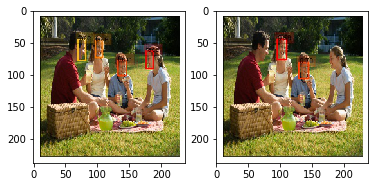

In [43]:

img1=mpimg.imread('./output_test/22_Picnic_Picnic_22_10_gt.jpg')
img2=mpimg.imread('./output_test/22_Picnic_Picnic_22_10.jpg')
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img1)
f.add_subplot(1,2, 2)
plt.imshow(img2)
plt.show()

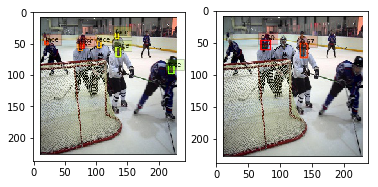

In [44]:

img1=mpimg.imread('./output_test/58_Hockey_icehockey_puck_58_285_gt.jpg')
img2=mpimg.imread('./output_test/58_Hockey_icehockey_puck_58_285.jpg')
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img1)
f.add_subplot(1,2, 2)
plt.imshow(img2)
plt.show()

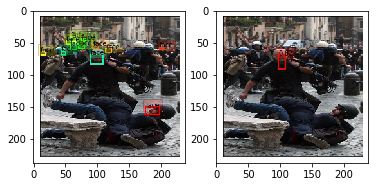

In [46]:

img1=mpimg.imread('./output_test/2_Demonstration_Demonstrators_2_188_gt.jpg')
img2=mpimg.imread('./output_test/2_Demonstration_Demonstrators_2_188.jpg')
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img1)
f.add_subplot(1,2, 2)
plt.imshow(img2)
plt.show()